<a href="https://colab.research.google.com/github/bulutirm/RealAndFakeFaceDetection/blob/main/Real_and_Fake_Face_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install imutils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import cv2
import urllib
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import random, os, glob
from imutils import paths
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from urllib.request import urlopen

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, SpatialDropout2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
dir_path = '/content/drive/MyDrive/Real and Fake Detection'

In [5]:
target_size = (224, 224)

waste_labels = {'training_real' : 0, 'training_fake' : 1}

In [6]:
def load_datasets(path):

  x = []
  labels = []

  image_paths = sorted(list(paths.list_images(path)))

  for image_path in image_paths:
    img = cv2.imread(image_path)
    img = cv2.resize(img, target_size)
    x.append(img)
    label = image_path.split(os.path.sep)[-2]
    labels.append(waste_labels[label])

  x, labels = shuffle(x, labels, random_state = 42)

  print(f"X boyutu: {np.array(x).shape}")
  print(f"Label sınıf sayısı: {len(np.unique(labels))} Gözlem sayısı: {len(labels)}")

  return x, labels  

In [7]:
x, labels = load_datasets(dir_path)

X boyutu: (2041, 224, 224, 3)
Label sınıf sayısı: 2 Gözlem sayısı: 2041


In [8]:
input_shape = (np.array(x[0]).shape[1], np.array(x[0]).shape[1], 3)
print(input_shape)

(224, 224, 3)


In [9]:
def visualize_img(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(10):
    ax = plt.subplot(5,5,n+1)
    plt.imshow(image_batch[n])
    plt.title(np.array(list(waste_labels.keys()))[to_categorical(labels, num_classes=2)[n]==1][0].title())
    plt.axis('off')

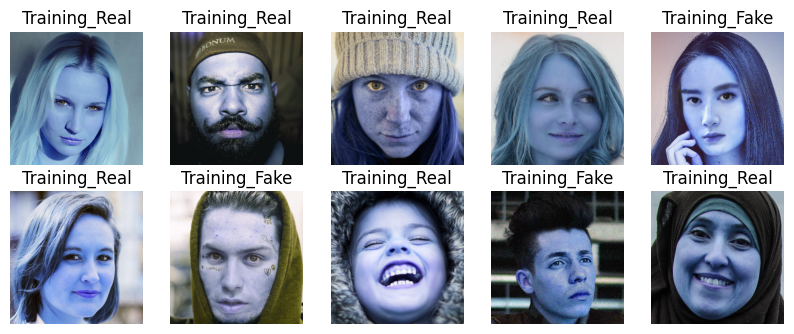

In [10]:
visualize_img(x, labels)

In [11]:
#Train veri seti için bir generator tanımlıyoruz
train = ImageDataGenerator(horizontal_flip = True,
                           validation_split = 0.2,
                           rescale = 1./255,
                           shear_range = 0.2,
                           zoom_range = 0.2,
                           width_shift_range = 0.1,
                           height_shift_range = 0.1)

#Test veri seti için bir generator tanımlıyoruz.
test = ImageDataGenerator(rescale = 1/255,
                          validation_split = 0.1)

In [12]:
train_generator = train.flow_from_directory(directory = dir_path,
                                             target_size = (target_size),
                                             class_mode = 'binary',
                                             subset = 'training')

test_generator = test.flow_from_directory(directory = dir_path,
                                          target_size = (target_size),
                                          batch_size = 251,
                                          class_mode = 'binary',
                                          subset = 'validation')

Found 1633 images belonging to 2 classes.
Found 204 images belonging to 2 classes.


In [14]:
#modelleme
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', 
                 input_shape = (input_shape), activation='relu'))
model.add(MaxPooling2D(pool_size=2, strides=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same',
                 activation='relu'))
model.add(MaxPooling2D(pool_size=2, strides=(2,2)))

model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same',
                 activation='relu'))
model.add(MaxPooling2D(pool_size=2, strides=(2,2)))

model.add(Flatten())

model.add(Dense(units=64, activation='relu'))
model.add(Dropout(rate=0.2))

model.add(Dense(units=32, activation='relu'))
model.add(Dropout(rate=0.2))

model.add(Dense(units=2, activation='softmax'))

In [15]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 56, 56, 32)        18464     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 28, 28, 32)      